4. XGBoost(eXtra Gradient Boost): GBM을 기반으로 함, 수행시간 및 과적합 규제 부재 등의 문제 해결
 - 파이썬 래퍼 XGBoost
 - 사이킷런 래퍼 XGBoost

4-1. 파이썬 래퍼 XGBoost

In [3]:
# 파이썬 래퍼 XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

print(xgb.__version__)

0.90


In [16]:
import xgboost as sgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 속성값으로 악성, 양성 종양을 분류하는 데이터
dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [19]:
# 악성암: 0, 양성암: 1
print(dataset.target_names)
print(cancer_df['target'].value_counts())

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터로 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64
(455, 30) (114, 30)


In [25]:
# XGBoost만의 전용 데이터 세트 생성
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label = y_test)

params = {'max_depth':3, #트리 최대 깊이
          'eta':0.1, # 학습률
          'objective':'binary:logistic', #이진분류 이므로, 목적함수는 이진 로지스틱
          'eval_metric':'logloss', # 오류함수의 평가 성능 지표는 Logloss
          'early_stopping':100} # 100번 반복동안 학습오류가 감소하지 않으면 조기 종료

num_rounds= 400 # 부스팅 반복 횟수

# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain,'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params= params, dtrain=dtrain, num_boost_round = num_rounds, early_stopping_rounds = 100, evals=wlist)

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547843
[2]	train-logloss:0.483753	eval-logloss:0.494248
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354146	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207938	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

In [28]:
# train()으로 학습을 수행하면 train-error와 eval-logloss가 지석적으로 감소함
# 파이썬 래퍼 XGBoost는 train() 함수를 호출해 학습이 완료된 모델 객체를 반환함
# 단, sklearn과 다르게 predict() 메서드는
# 예측 결과 클래스값이 아닌, 예측 결과를 추정할 수 있는 확률 값을 반환함

pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값을 결정하여 리스트 객체에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
def get_clf_eval(y_test, pred, pred_proba):
    # 오차행렬: [[TN, FP], [FN, TP]]
    confusion = confusion_matrix(y_test, pred)
    # 정확도: (TP + TN) / (TP + TN + FP + FN)
    accuracy = accuracy_score(y_test, pred)
    # 정밀도: TP / (FP + TP)
    precision = precision_score(y_test, pred)
    # 재현률: TP / (FN + TP)
    recall = recall_score(y_test, pred)
    # F1
    f1 = f1_score(y_test, pred)
    # AUC
    roc_score = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0: .4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {0:.4f}'.format(accuracy, precision, recall, f1, roc_score))

# 테스트 데이터의 결과값(0,1), 테스트 데이터에 대한 예측값(0,1), 예측에 대한 확률값(0~1)
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 :  0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9737


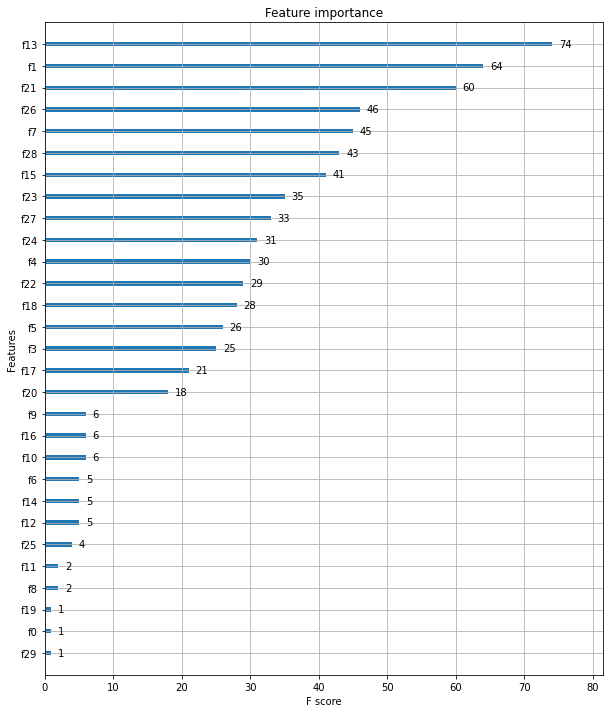

In [39]:
# 사이킷런과 달리,  xgboost 패키지에 내장된 시각화 기능을 통해 피처의 중요도 시각화 가능
# 단, xgboost 넘파이 기반의 피처 데이터로 학습시에는 피처명을 알 수 없으므로
# f0, f1과 같이 피처 순서별로 f자 뒤에 순서를 붙여 x축에 피처들로 나열함
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

4-2. 사이킷런 래퍼 XGBoost (파이썬 래퍼 XGBoost와 하이퍼 파라미터명 차이가 존재함)
 - GridSearchCV를 통해 하이퍼 파라미터 튜닝 가능

In [43]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier(분류를 위한 래퍼 클래스) import
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

# 위의 파이썬 래퍼와 동일한 결과가 나옴
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 :  0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9737


In [48]:
# sklearn 래퍼 XGBoost에서도 조기 중단 수행 가능
# fit()에 조기 중단 관련 파라미터 입력
# 1. 평가 지표가 향상될 수 있는 반복 횟수를 정의하는 early_stopping_rounds
# 2. 조기 중단을 위한 평가 지표인 eval_metric
# 3. 성능 평가를 수행할 데이터세트인 eval_set (학습 데이터가 아닌, 별도의 데이터 세트 여야함. ex) test dataset )

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                eval_set=evals, verbose=False) #verbose=False: 출력 생략
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도 :  0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9649


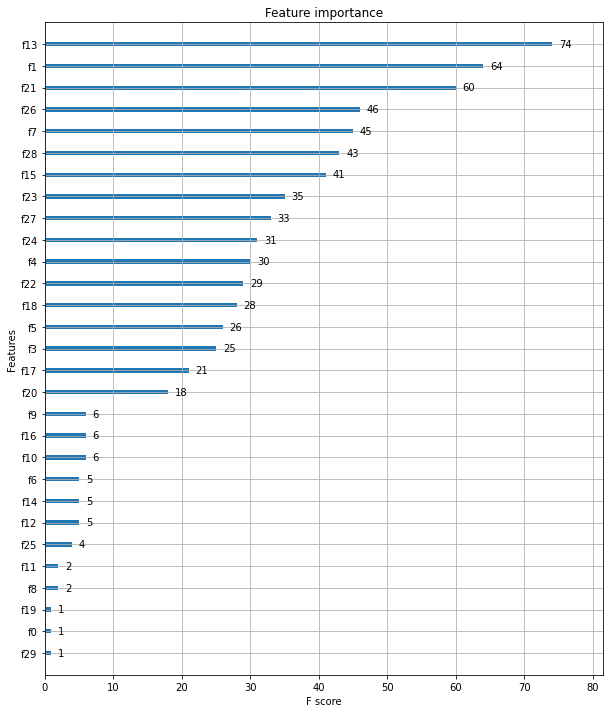

In [49]:
# 피처의 중요도를 시각화하는 모듈인 plot_importance()에
# 사이킷런 래퍼 클래스를 입력해 시각화 가능
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper 클래스를 입력해도 무방함
plot_importance(xgb_wrapper, ax=ax)

5. LightGBM
 - 파이썬 래퍼 클래스
 - 사이킷런 래퍼 클래스

In [52]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트(사이킷런 래퍼 클래스)
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 80%, 20%로 학습, 테스트용 데이터 만듬
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

# XGBoost와 동일하게 n_estimators 400
lgbm_wrapper = LGBMClassifier(n_estimators = 400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100,
                 eval_metric='logloss', eval_set = evals, verbose=False)

preds= lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 2 75]]
정확도 :  0.9474, 정밀도: 0.9494, 재현율: 0.9740, F1: 0.9615, AUC: 0.9474


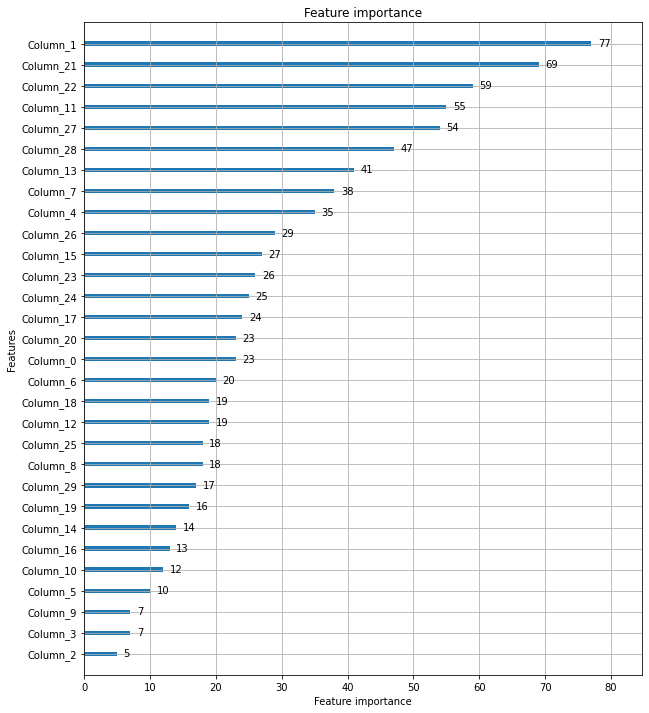

In [53]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)